<a href="https://colab.research.google.com/github/eecoubrough/Keras_Assignment/blob/main/Part_1_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Medical Image Analysis Example
A simple convolutional neural network model trained using a simple pathology image dataset.

To use GPU acceleration make sure to change your runtime type in Google Colab to GPU.

## Python Imports
This section will load the necessary python packages to the instance.

In [1]:
# Built-in Imports
import random

In [2]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Keras Imports
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dataset Downloader
This section will download the BloodMNIST dataset as a NumPy array object to the Google Colab instance. Note that the dataset does need to be redownloaded every time an instance is created.

In [4]:
# The dataset selected is BloodMNIST
# If desired, a different MedMNIST dataset could be used simply by specifying the desired dataset name.
DATA_NAME = "BloodMNIST"

In [5]:
# Retrieves the dataset from GitHub
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]

--2024-03-31 21:31:22--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27766 (27K) [text/plain]
Saving to: ‘info.py’

info.py             100%[===================>]  27.12K  --.-KB/s    in 0.001s  

2024-03-31 21:31:23 (18.9 MB/s) - ‘info.py’ saved [27766/27766]



In [6]:
# Downloads the dataset file hosted on Zenodo.
file_path = get_file(fname="dataset.npz",
                     origin=data["url"],
                     md5_hash=data["MD5"])

35461855/35461855 [==============================] - 3s 0us/step


In [7]:
# Loads the downloaded NumPy object, saving it to the variable 'dataset'.
dataset = np.load(file_path)

# Gets the training images and labels from the NumPy object.
train_x = dataset["train_images"]
train_y = dataset["train_labels"]

# Gets the validation images and labels from the NumPy object.
val_x = dataset["val_images"]
val_y = dataset["val_labels"]

# Gets the testing images and labels from the NumPy object.
test_x = dataset["test_images"]
test_y = dataset["test_labels"]

## Data Exploration
In this section we have a look at our data, their distributions to see if it is ready to be used within our machine learning algorithm.

In [8]:
# Print the shape of one of the images in your dataset to ensure the images are in the expected shape format.
print(train_x[0].shape)

(28, 28, 3)


In [9]:
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]

# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)

# Prints the counts for each label from each dataset (used to check the distributions of data in each of the eight classes to ensure there is no unexpected discepencies).
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]),
                            np.append(val_counts, [sum(val_counts)]),
                            np.append(test_counts, [sum(test_counts)]))),
                   index=labels, columns=["Train", "Val", "Test"]))

                                                    Train   Val  Test
basophil                                              852   122   244
eosinophil                                           2181   312   624
erythroblast                                         1085   155   311
immature granulocytes(myelocytes, metamyelocyte...   2026   290   579
lymphocyte                                            849   122   243
monocyte                                              993   143   284
neutrophil                                           2330   333   666
platelet                                             1643   235   470
total                                               11959  1712  3421


11852: platelet


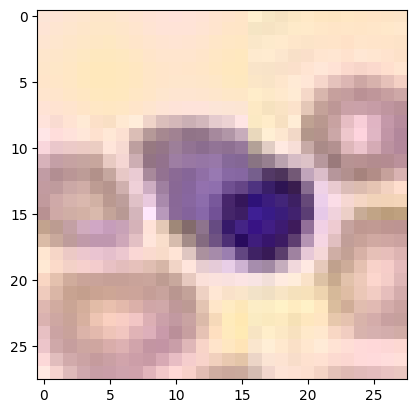

In [10]:
# Displays a random image from training dataset.
index = random.randint(0, len(train_x))
print(f"{index}: {labels[train_y[index][0]]}")
plt.imshow(train_x[random.randint(0, len(train_x))])

## Data Processing
In this section we will create a data loader for algorithm that will dynamically load and augment the data when needed.

In [11]:
# Defines the data generator that will be used to augment the images as they are loaded.
data_generator = ImageDataGenerator(featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    horizontal_flip=True,
                                    vertical_flip=True)

In [12]:
data_generator.fit(np.append(train_x, val_x, 0))

---
# **Part 1 - Covnet with same architechture and training regime**

## Model Definition
In this section we will define the neural network arcitecture.

In [13]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Defines the first convolutional layer with max pooling.
conv_1 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(input)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)

# Defines the second convolutional layer with max pooling.
conv_2 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(pool_1)
pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)

# Flattens the outputs of the convolutoonal layers into a one dimensional array.
flatten = layers.Flatten()(pool_2)

# Defines the output layer of the model a number of output nodes equal to the number of classes.
output = layers.Dense(units=8, activation="softmax")(flatten)

# Initilises the defined model and prints summary of the model.
model_1 = Model(inputs=input, outputs=output, name="Model_1")
model_1.summary()

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 800)               0   

## Model Training
This is where we define the training options and then train the model.


In [14]:
# Defines the parameters used during training.
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

In [15]:
# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)
model_1.compile(optimizer=optimiser, loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
# We use the data generator to pass the training and validation data to the model to train it.
history_1 = model_1.fit(data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE),
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/10
186/186 [==============================] - 17s 83ms/step - loss: 1.9333 - accuracy: 0.2942 - val_loss: 1.7874 - val_accuracy: 0.3756
Epoch 2/10
186/186 [==============================] - 10s 55ms/step - loss: 1.6923 - accuracy: 0.3966 - val_loss: 1.5973 - val_accuracy: 0.4282
Epoch 3/10
186/186 [==============================] - 10s 56ms/step - loss: 1.5213 - accuracy: 0.4536 - val_loss: 1.4528 - val_accuracy: 0.4854
Epoch 4/10
186/186 [==============================] - 10s 51ms/step - loss: 1.3913 - accuracy: 0.5068 - val_loss: 1.3392 - val_accuracy: 0.5333
Epoch 5/10
186/186 [==============================] - 9s 50ms/step - loss: 1.2895 - accuracy: 0.5486 - val_loss: 1.2366 - val_accuracy: 0.5678
Epoch 6/10
186/186 [==============================] - 10s 52ms/step - loss: 1.2056 - accuracy: 0.5836 - val_loss: 1.1578 - val_accuracy: 0.6005
Epoch 7/10
186/186 [==============================] - 10s 54ms/step - loss: 1.1311 - accuracy: 0.6136 - val_loss: 1.0873 - val_accuracy: 

## Plot Learning Curves
This is where we visualise the training of the model.

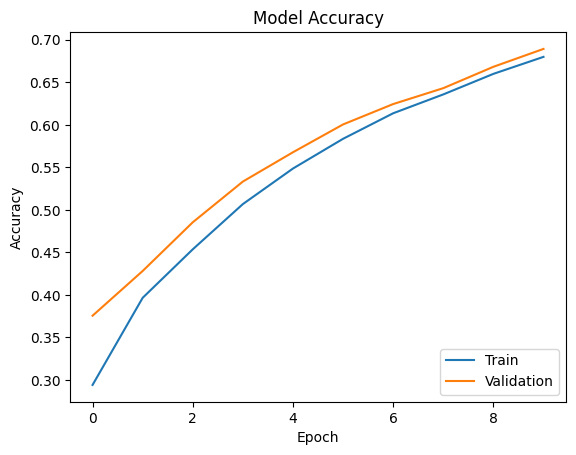

In [17]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])

# Add plot title.
plt.title('Model Accuracy')

# Add plot axes labels.
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Add plot legend to distinguish between training and validation accuracy lines.
plt.legend(['Train', 'Validation'], loc='lower right')

# Show the plot.
plt.show()

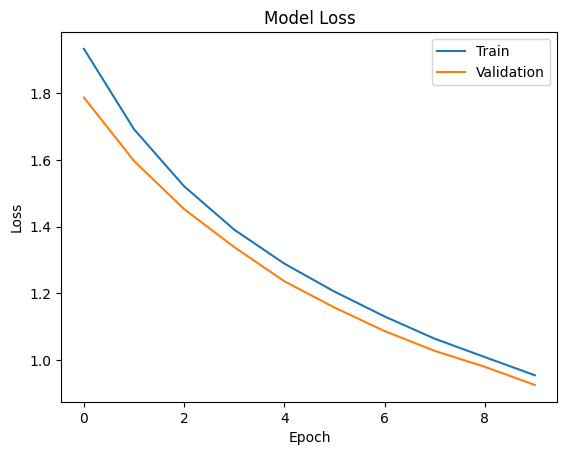

In [18]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])

# Add plot title.
plt.title('Model Loss')

# Add plot axes labels.
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Add plot legend to distinguish between training and validation accuracy lines.
plt.legend(['Train', 'Validation'], loc='upper right')

# Show the plot.
plt.show()



---
#**Part 2 - A network with only dense layers**


## Model Definition
In this section we will define the neural network arcitecture.

In [19]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Flattens the outputs of the input layer into a 1D array.
flatten = layers.Flatten()(input)

# Dense layer 1 with 7 units and ReLU activation.
dense_1 = layers.Dense(units=7, activation="relu")(flatten)

# Dense layer 2 with 5 units and ReLU activation.
dense_2 = layers.Dense(units=5, activation="relu")(dense_1)

# Defines the output layer of the model with the number of output nodes equal to the number of classes in the dataset,
# using the softmax activation function to generate probabilities for each class.
output = layers.Dense(units=8, activation="softmax")(dense_2)

# Initializes the defined model with the input and output layers.
model_2 = Model(inputs=input, outputs=output, name="Model_2")

# Print the summary of the model.
model_2.summary()

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 2352)              0         
                                                                 
 dense_1 (Dense)             (None, 7)                 16471     
                                                                 
 dense_2 (Dense)             (None, 5)                 40        
                                                                 
 dense_3 (Dense)             (None, 8)                 48        
                                                                 
Total params: 16559 (64.68 KB)
Trainable params: 16559 (64.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Model Training
This is where we define the training options and then train the model.


In [20]:
# Defines the parameters used during training.
# Since the training regime is to be the same as for model_1, these parameters are the same as they were previously.
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

In [21]:
# Define the optimizer with the above specified learning rate.
optimiser = SGD(learning_rate=LEARNING_RATE)

# Compile the model with the above defined optimizer, categorical crossentropy loss, and accuracy metric.
model_2.compile(optimizer=optimiser, loss="categorical_crossentropy", metrics=["accuracy"])

In [22]:
# We use the data generator to pass the training and validation data to the model to train it.
history_2 = model_2.fit(data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE),
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/10
186/186 [==============================] - 3s 15ms/step - loss: 2.0538 - accuracy: 0.2026 - val_loss: 1.9991 - val_accuracy: 0.2471
Epoch 2/10
186/186 [==============================] - 2s 10ms/step - loss: 1.9702 - accuracy: 0.2723 - val_loss: 1.9344 - val_accuracy: 0.2728
Epoch 3/10
186/186 [==============================] - 2s 9ms/step - loss: 1.9097 - accuracy: 0.2910 - val_loss: 1.8794 - val_accuracy: 0.2792
Epoch 4/10
186/186 [==============================] - 2s 10ms/step - loss: 1.8601 - accuracy: 0.2994 - val_loss: 1.8399 - val_accuracy: 0.3002
Epoch 5/10
186/186 [==============================] - 2s 11ms/step - loss: 1.8295 - accuracy: 0.3058 - val_loss: 1.8134 - val_accuracy: 0.3148
Epoch 6/10
186/186 [==============================] - 2s 11ms/step - loss: 1.8086 - accuracy: 0.3173 - val_loss: 1.7963 - val_accuracy: 0.3289
Epoch 7/10
186/186 [==============================] - 2s 10ms/step - loss: 1.7922 - accuracy: 0.3241 - val_loss: 1.7808 - val_accuracy: 0.3364


## Plot Learning Curves
This is where we visualise the training of the model.

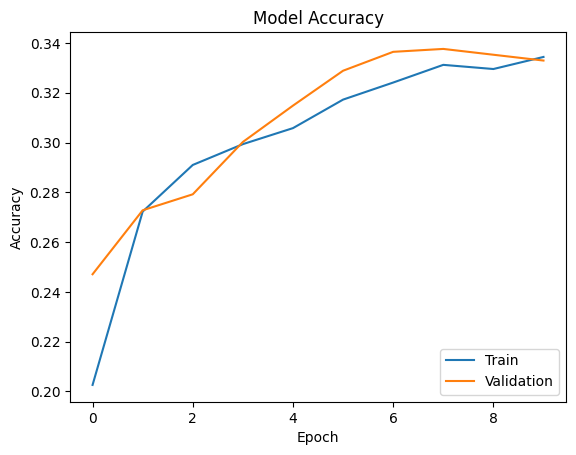

In [23]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])

# Add plot title.
plt.title('Model Accuracy')

# Add plot axes labels.
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Add plot legend to distinguish between training and validation accuracy lines.
plt.legend(['Train', 'Validation'], loc='lower right')

# Show the plot.
plt.show()

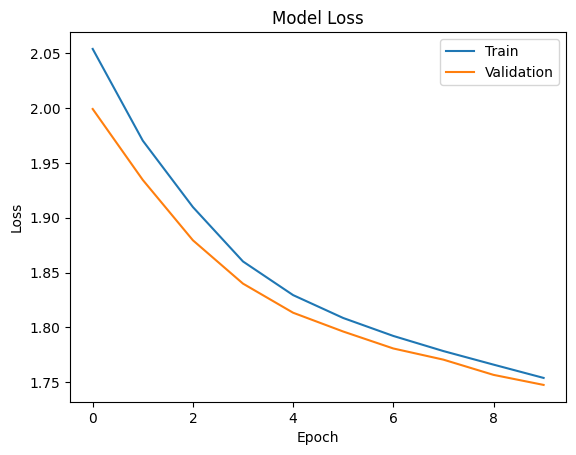

In [24]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])

# Add plot title.
plt.title('Model Loss')

# Add plot axes labels.
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Add plot legend to distinguish between training and validation accuracy lines.
plt.legend(['Train', 'Validation'], loc='upper right')

# Show the plot.
plt.show()


---
#**Part 3 - A deep network of my own design**

## Data Augmentation
In this section we will create a data loader for algorithm that will dynamically load and augment the data when needed.

In [25]:
# Defines the data generator that will be used to augment the images as they are loaded.
data_generator = ImageDataGenerator(featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    horizontal_flip=True,
                                    vertical_flip=True)

In [26]:
data_generator.fit(np.append(train_x, val_x, 0))

## Model Definition
In this section we will define the neural network arcitecture.

In [27]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Defines the convolutional layer with max pooling.
conv_1 = layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_regularizer=regularizers.l2(0.0001))(input)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)

# Flattens the outputs of the convolutional layers into a one-dimensional array.
flatten = layers.Flatten()(pool_1)

# Dense layer with ReLU activation
dense = layers.Dense(units=16, activation="relu")(flatten)

# Defines the output layer of the model with a number of output nodes equal to the number of classes (8 classes for BloodMNIST),
# using the softmax activation function to generate probabilities for each class.
output = layers.Dense(units=8, activation="softmax", kernel_regularizer=regularizers.l2(0.0001))(dense)

# Initializes the defined model.
model_3 = Model(inputs=input, outputs=output, name="Model_3")

# Print the model summary.
model_3.summary()

Model: "Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 5408)              0         
                                                                 
 dense_4 (Dense)             (None, 16)                86544     
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                           

## Model Training
This is where we define the training options and then train the model.

Through testing different values for the training parameters, I determined that a smaller batch size and more epochs was optimum.


In [28]:
# Defining the parameters used during training.
BATCH_SIZE = 32 #Batch size should always be a power of 2 GPU allocation purposes (quicker as no additional calculations required by the computer)
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

In [29]:
# Define the optimizer with the above specified learning rate.
optimiser = SGD(learning_rate=LEARNING_RATE)

# Compile the model with the above defined optimizer, categorical crossentropy loss, and accuracy metric.
model_3.compile(optimizer=optimiser, loss="categorical_crossentropy", metrics=["accuracy"])

In [30]:
# Train the model using training data generated in batches by the data generator.
history_3 = model_3.fit(
    # Training data generator that yields augmented batches of images and their corresponding one-hot encoded labels.
    data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE),
    # Number of steps (batches) per epoch is calculated as the total number of training samples divided by the batch size.
    steps_per_epoch=len(train_x) / BATCH_SIZE,
    # Validation data generator that yields batches of validation images and their corresponding one-hot encoded labels.
    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE),
    # Number of steps (batches) per validation epoch is calculated as the total number of validation samples divided by the batch size.
    validation_steps=len(val_x) / BATCH_SIZE,
    # Number of epochs to train the model.
    epochs=NUM_EPOCHS
)

Epoch 1/20
373/373 [==============================] - 8s 20ms/step - loss: 1.6634 - accuracy: 0.4213 - val_loss: 1.4265 - val_accuracy: 0.5537
Epoch 2/20
373/373 [==============================] - 7s 19ms/step - loss: 1.2947 - accuracy: 0.5815 - val_loss: 1.1871 - val_accuracy: 0.6221
Epoch 3/20
373/373 [==============================] - 8s 21ms/step - loss: 1.1193 - accuracy: 0.6341 - val_loss: 1.0452 - val_accuracy: 0.6659
Epoch 4/20
373/373 [==============================] - 8s 22ms/step - loss: 1.0021 - accuracy: 0.6732 - val_loss: 0.9550 - val_accuracy: 0.6852
Epoch 5/20
373/373 [==============================] - 8s 22ms/step - loss: 0.9169 - accuracy: 0.7008 - val_loss: 0.8664 - val_accuracy: 0.7185
Epoch 6/20
373/373 [==============================] - 7s 19ms/step - loss: 0.8423 - accuracy: 0.7313 - val_loss: 0.8036 - val_accuracy: 0.7442
Epoch 7/20
373/373 [==============================] - 7s 18ms/step - loss: 0.7866 - accuracy: 0.7476 - val_loss: 0.7462 - val_accuracy: 0.7640



---

# Comparing the models

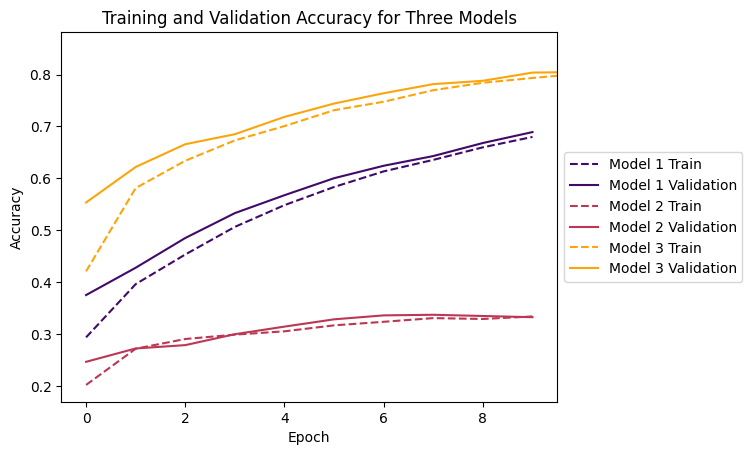

In [32]:
# Create colour palette by getting three colors from the Inferno colormap
colours = [cm.inferno(0.2), cm.inferno(0.5), cm.inferno(0.8)]

# Plot training accuracy for Model 1 (dashed line)
plt.plot(history_1.history['accuracy'], label='Model 1 Train', linestyle='dashed', color=colours[0])
# Plot validation accuracy for Model 1 (solid line)
plt.plot(history_1.history['val_accuracy'], label='Model 1 Validation', color=colours[0])

# Plot training accuracy for Model 2 (dashed line)
plt.plot(history_2.history['accuracy'], label='Model 2 Train', linestyle='dashed', color=colours[1])
# Plot validation accuracy for Model 2 (solid line)
plt.plot(history_2.history['val_accuracy'], label='Model 2 Validation', color=colours[1])

# Plot training accuracy for Model 3 (dashed line)
plt.plot(history_3.history['accuracy'], label='Model 3 Train', linestyle='dashed', color=colours[2])
# Plot validation accuracy for Model 3 (solid line)
plt.plot(history_3.history['val_accuracy'], label='Model 3 Validation', color=colours[2])

# Add plot title
plt.title('Training and Validation Accuracy for Three Models')

# Add axis labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Set x-axis limit to 10 epochs
plt.xlim(-0.5, 9.5)

# Add plot legend to the right of the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show plot
plt.show()

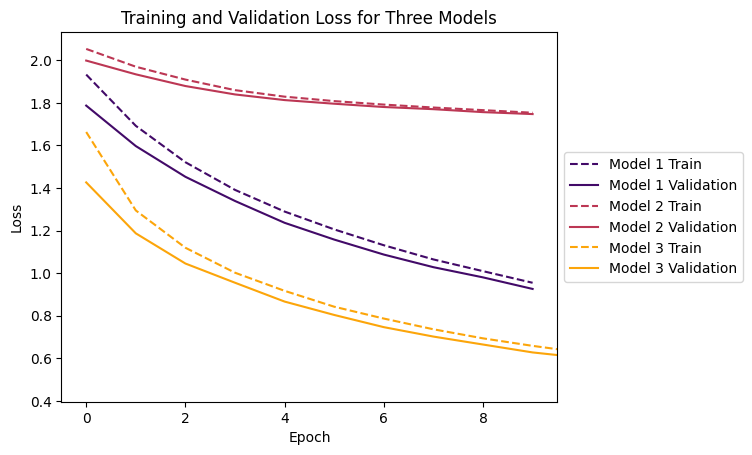

In [33]:
# Create colour palette by getting three colors from the Inferno colormap
colours = [cm.inferno(0.2), cm.inferno(0.5), cm.inferno(0.8)]

# Plot training loss for Model 1 (dashed line)
plt.plot(history_1.history['loss'], label='Model 1 Train', linestyle='dashed', color=colours[0])
# Plot validation loss for Model 1 (solid line)
plt.plot(history_1.history['val_loss'], label='Model 1 Validation', color=colours[0])

# Plot training loss for Model 2 (dashed line)
plt.plot(history_2.history['loss'], label='Model 2 Train', linestyle='dashed', color=colours[1])
# Plot validation loss for Model 2 (solid line)
plt.plot(history_2.history['val_loss'], label='Model 2 Validation', color=colours[1])

# Plot training loss for Model 3 (dashed line)
plt.plot(history_3.history['loss'], label='Model 3 Train', linestyle='dashed', color=colours[2])
# Plot validation loss for Model 3 (solid line)
plt.plot(history_3.history['val_loss'], label='Model 3 Validation', color=colours[2])

# Add plot title
plt.title('Training and Validation Loss for Three Models')

# Add axis labels
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Set x-axis limit to 10 epochs
plt.xlim(-0.5, 9.5)

# Add plot legend to the right of the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show plot
plt.show()